In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    classification_report,
    precision_score,
    recall_score
)
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import cross_val_score

warnings.filterwarnings(
    "ignore", category=DeprecationWarning
)  # to avoid deprecation warnings

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=[
        "#4B9AC7",
        "#4BE8E0",
        "#9DD4F3",
        "#97FBF6",
        "#2A7FAF",
        "#23B1AB",
        "#0E3449",
        "#015955",
    ]
)
pio.templates.default = "jedha"

pio.renderers.default = "svg"  # to be replaced by "iframe" if working on JULIE

# EDA

Let's have a look at the dataset

In [2]:
dataset = pd.read_csv('conversion_data_train.csv')
print(dataset.shape)
dataset.head()

(284580, 6)


,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


In [4]:
dataset.isnull().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

There are 6 columns with 284k lines and no missing data
- Country : Origin country among China, Germany, UK and US
- Age : Age of the user
- New_User : If it is a new user or not
- Source : How the user were obtained
- Total_pages_visites : Number of pages visited by the user
- Converted : Target

Let's have a first look at the distribution

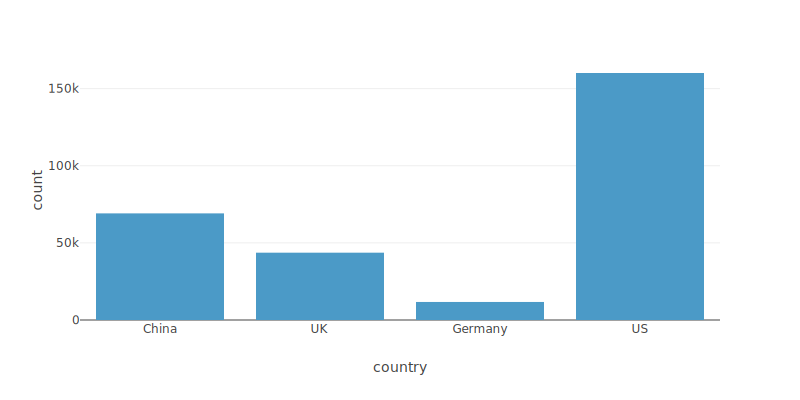

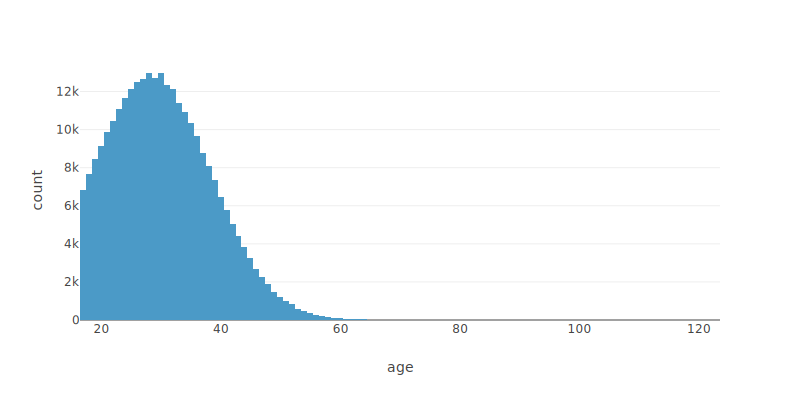

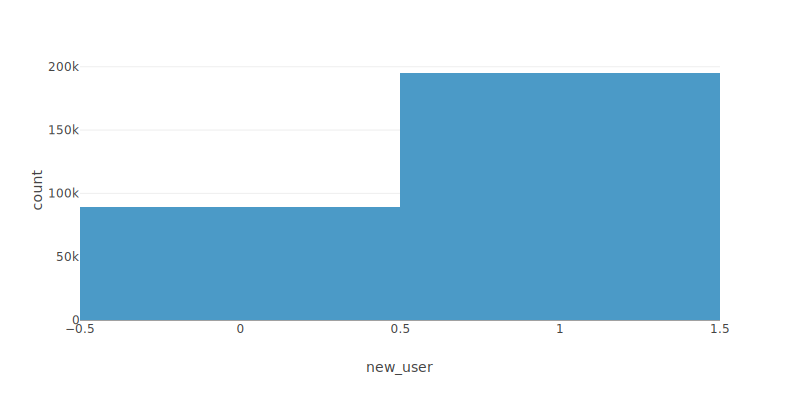

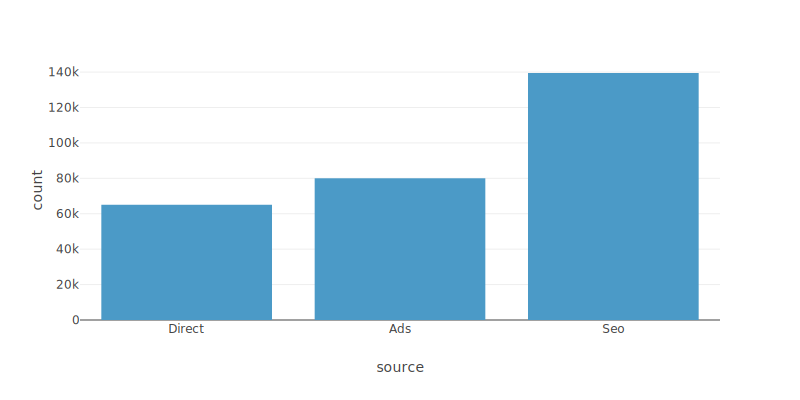

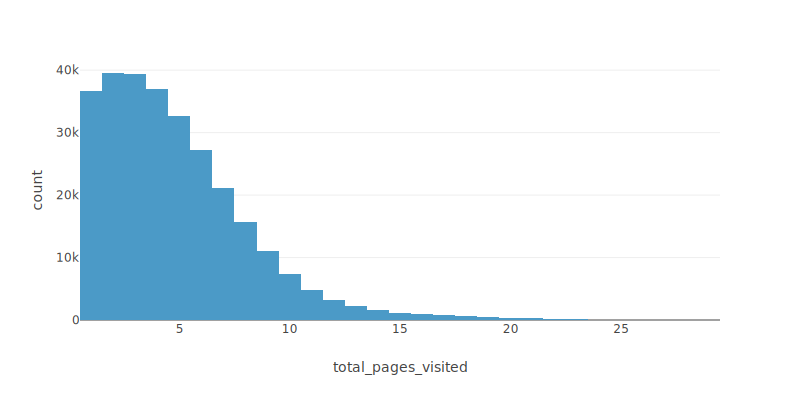

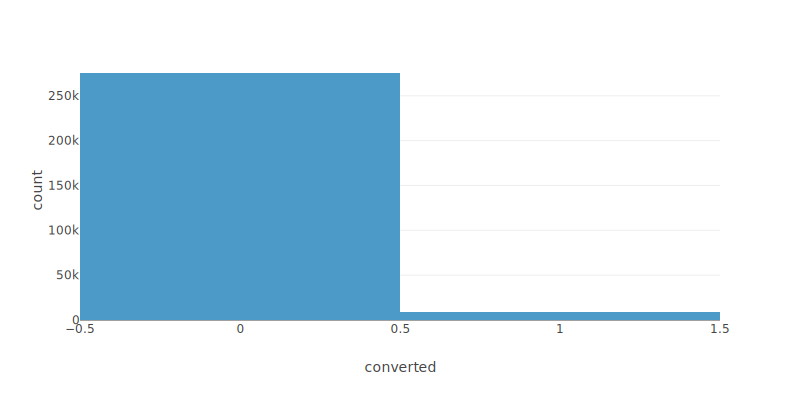

In [5]:
for c in dataset.columns:
    fig = px.histogram(dataset, c, width=800, height=400)
    fig.show()

The first analysis
- US and China are the main countries is term of visitors
- SEO is the main source
- The visitors are visiting just a few page in average
- The conversion rate seems low given the number of visitors

Let's have a look at the histogram for converted visitor

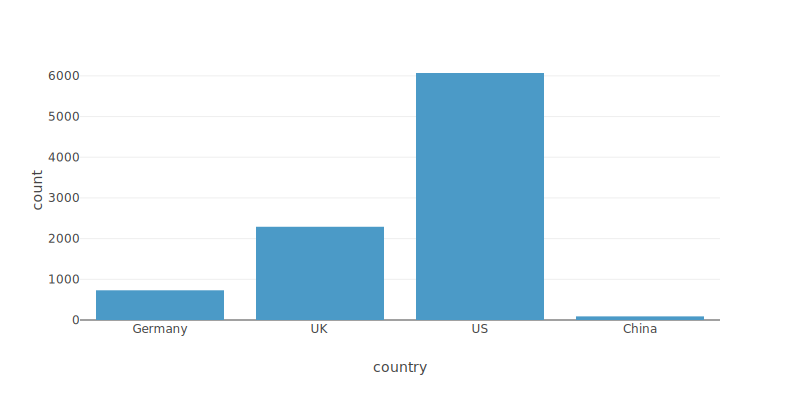

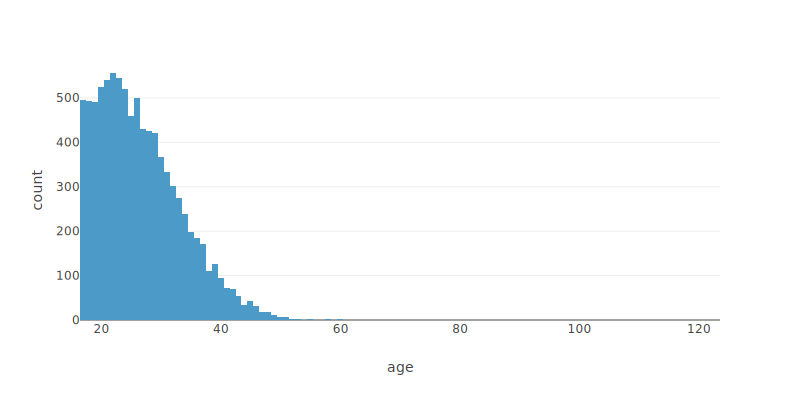

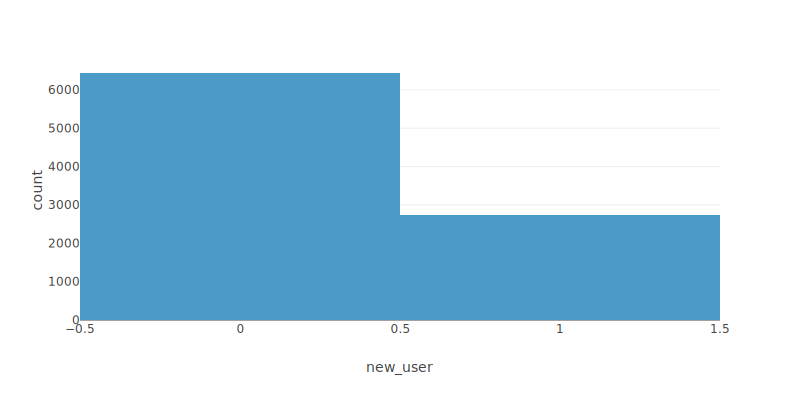

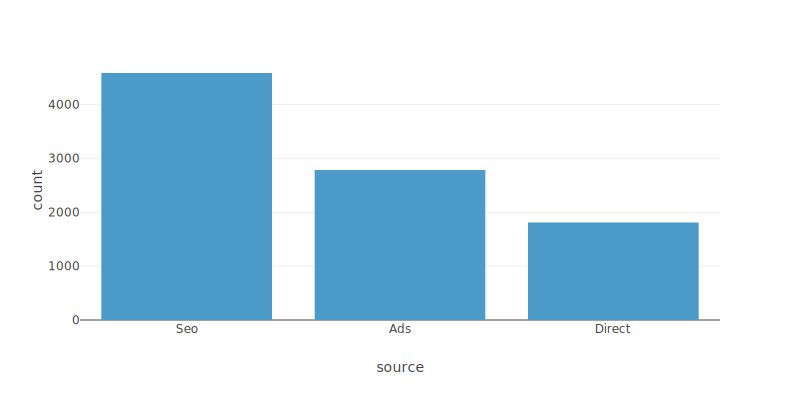

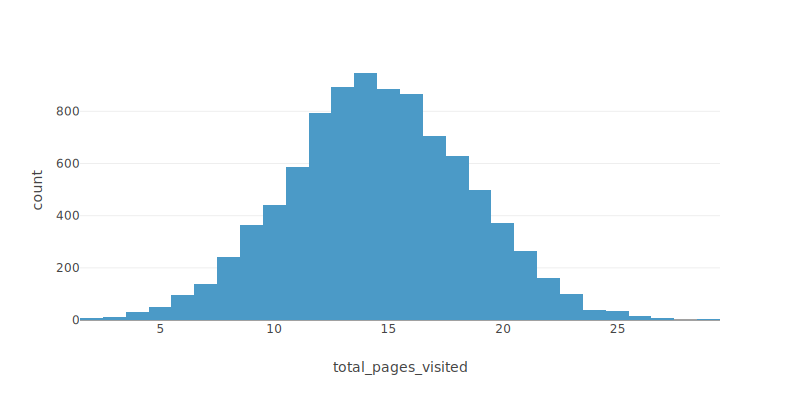

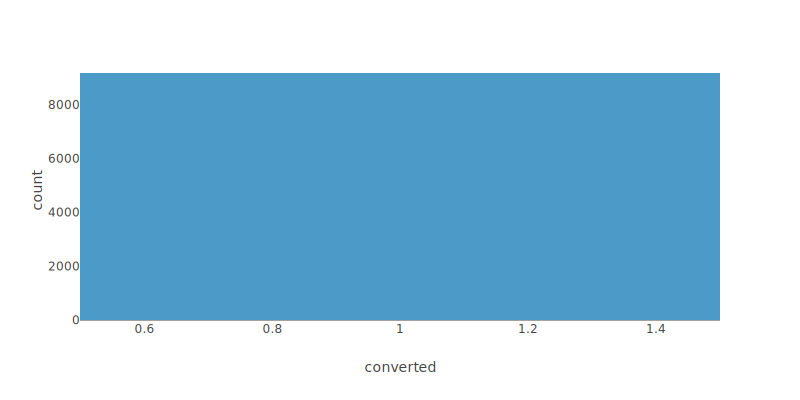

In [6]:
for c in dataset.columns:
    fig = px.histogram(dataset[dataset['converted']==1], c, width=800, height=400)
    fig.show()

what we can see
- USA is the main country in term of numbers of conversion
- The converted customers seems to be younger than the average visitor
- The pick of number of page visited is around 15

Let's confirm this by looking at the average conversion by category

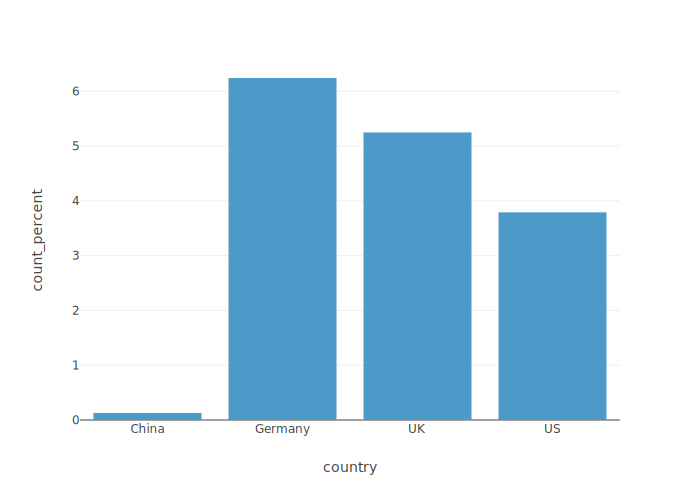

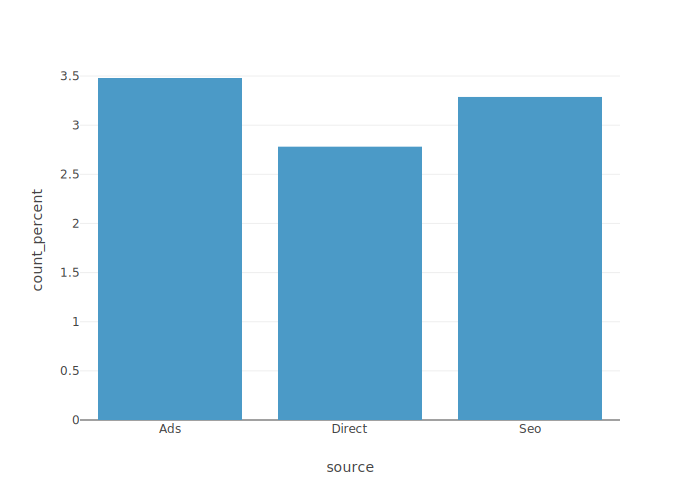

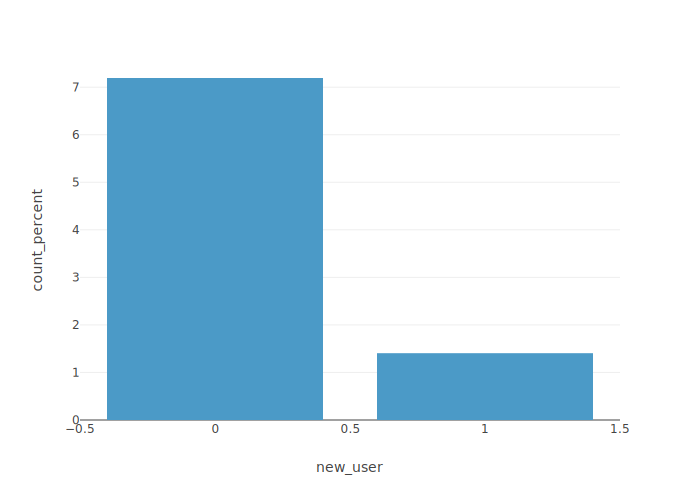

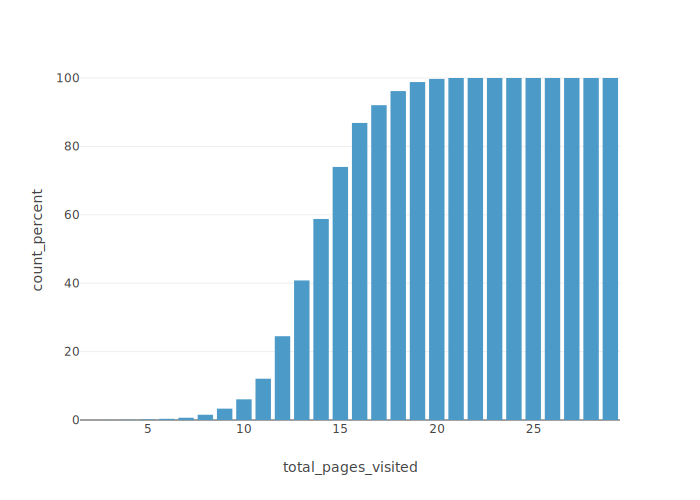

In [7]:
for c in ['country',"source","new_user","total_pages_visited"]:
    df_temp = dataset.groupby([c,"converted"])['age'].count().reset_index()
    df_temp = df_temp.rename(columns={"age": "count"})
    df_temp['count_country'] = df_temp.groupby(c)['count'].transform('sum')
    df_temp["count_percent"] = df_temp['count']/df_temp["count_country"]*100


    fig = px.bar(df_temp[df_temp["converted"]==1],x=c,y="count_percent")
    fig.show()

What can be seen : 
- The highest converting rate is coming from Germany and the UK. There are almost no conversion in China
- Each source seems to have the same conversion rate
- High conversion for historic customer
- The highest the number of page, the higher the conversion rate. After 20 page visiting, there is a 100% conversion rate

# Preprocessing

In [3]:
#Let's create our target and our dataset 
target_variable = "converted"
X = dataset.drop(target_variable,axis=1)
Y = dataset.loc[:,target_variable]


In [4]:
# Let's split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y)


In [5]:
#Let's create a preprocessing pipeline depending on the type of features

numeric_features = ['age', 'total_pages_visited']
categorical_features = ['country', 'source','new_user']

# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' mean
    ('scaler', StandardScaler())

])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [6]:
# Preprocessings on train set
X_train = preprocessor.fit_transform(X_train)

# Preprocessings on test set
X_test = preprocessor.transform(X_test) # Don't fit again !!


In [7]:
# Train model
print("Train model...")
classifier = LogisticRegression(max_iter = 1000)
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [8]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred[:5])
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred[:5])
print()


Predictions on training set...
...Done.
[0 0 0 0 0]

Predictions on test set...
...Done.
[0 0 0 0 0]



In [9]:
# Basic metrics
print("--- Basic Metrics ---")
print("Accuracy (training): {:.4f}".format(accuracy_score(Y_train, Y_train_pred)))
print("Accuracy (test): {:.4f}".format(accuracy_score(Y_test, Y_test_pred)))
print()

print("F1-score (training): {:.4f}".format(f1_score(Y_train, Y_train_pred)))
print("F1-score (test): {:.4f}".format(f1_score(Y_test, Y_test_pred)))
print()

print("Precision (training): {:.4f}".format(precision_score(Y_train, Y_train_pred)))
print("Precision (test): {:.4f}".format(precision_score(Y_test, Y_test_pred)))
print()

print("Recall (training): {:.4f}".format(recall_score(Y_train, Y_train_pred)))
print("Recall (test): {:.4f}".format(recall_score(Y_test, Y_test_pred)))
print()

--- Basic Metrics ---
Accuracy (training): 0.9864
Accuracy (test): 0.9857

F1-score (training): 0.7660
F1-score (test): 0.7546

Precision (training): 0.8576
Precision (test): 0.8463

Recall (training): 0.6921
Recall (test): 0.6808



The accuracy is very good with 98% on both dataset, but the recall is relatively low with 68% on the test set

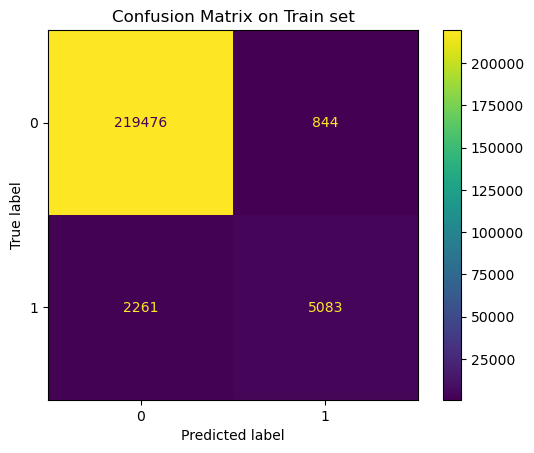

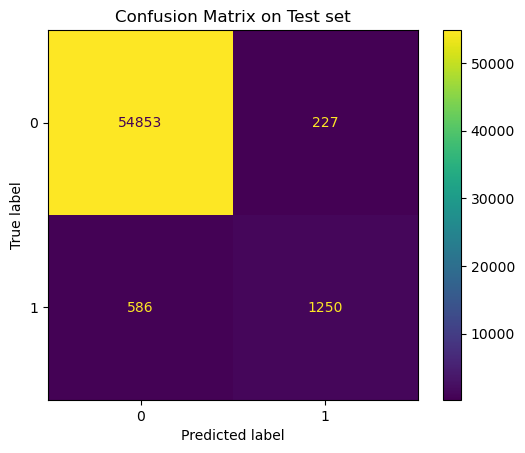

In [10]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

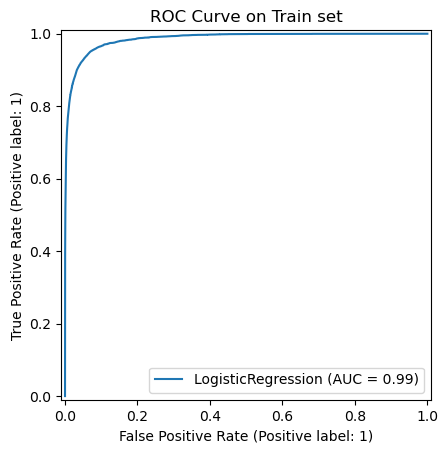

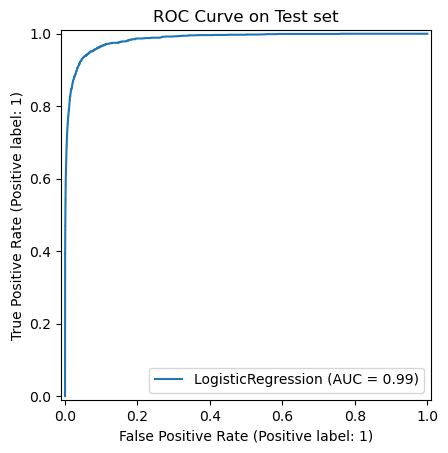

In [11]:
# Visualize ROC curves
_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="ROC Curve on Train set"
)  # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(
    classifier, X_train, Y_train, ax=ax
)  # RocCurveDisplay from sklearn
plt.show()

_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="ROC Curve on Test set"
)  # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(
    classifier, X_test, Y_test, ax=ax
)  # RocCurveDisplay from sklearn
plt.show()

In [12]:
print('Coefficients of the Logistic regression model:')
classifier.coef_

Coefficients of the Logistic regression model:


array([[-0.59858916,  2.54947542,  3.51724943,  3.2709922 ,  2.93048114,
        -0.18396326, -0.03190371, -1.68289847]])

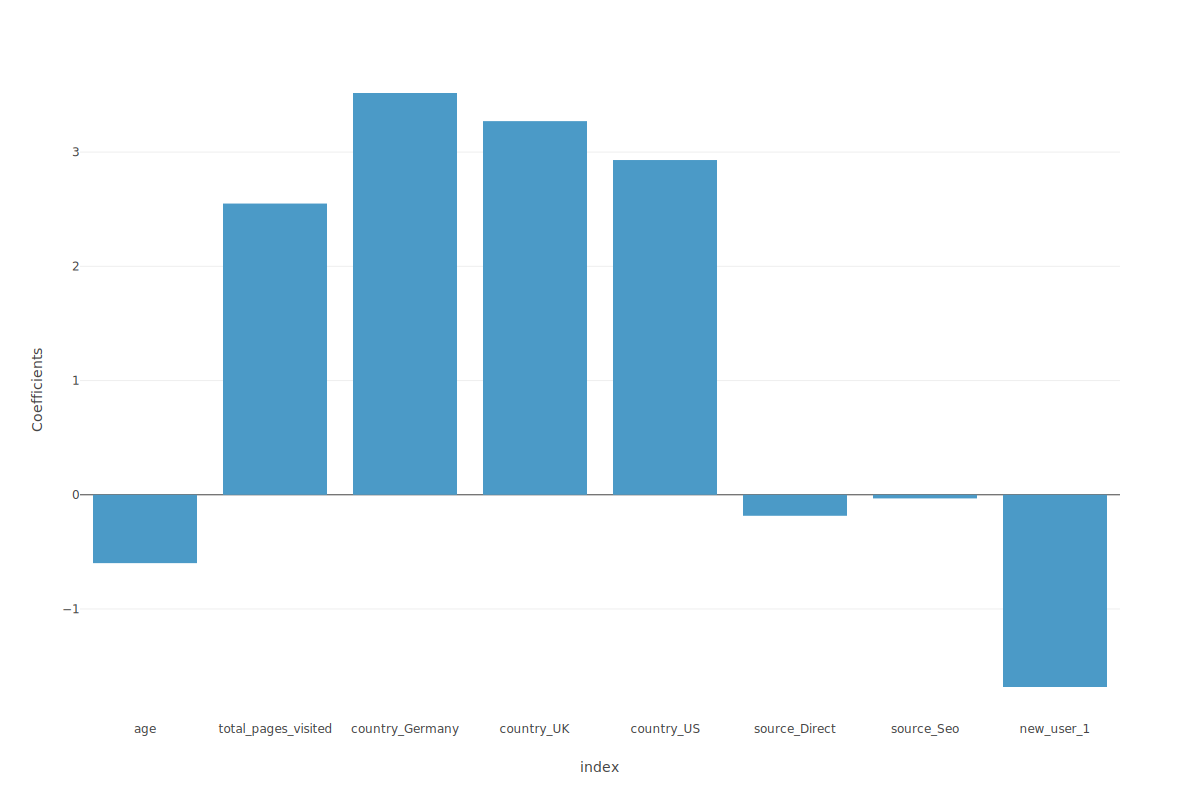

In [14]:
col_names = list(preprocessor.transformers_[0][1].get_feature_names_out()) + list(preprocessor.transformers_[1][1].get_feature_names_out())


coefs = pd.DataFrame(
   classifier.coef_.transpose(),
   columns=['Coefficients'], index=col_names
).reset_index()


fig = px.bar(coefs,x="index",y="Coefficients")
fig.update_layout(
    width=1200, 
    height=800, 
)
fig.show()

The logistic regression seems to have a good performance. Here is what we can conclude : 

**Geographic targeting opportunity**: The massive difference in conversion rates between China and Western countries (Germany, UK, US) suggests either:
- A product/market fit issue in China
- A localization/cultural adaptation opportunity
- Potential technical or payment barriers for Chinese users

**Retention matters**: The strong negative coefficient for new users indicates that focusing on bringing users back could significantly improve conversion rates

**Engagement drives conversion**: The strong positive coefficient for pages visited suggests that strategies to increase site engagement could pay off in higher conversions

**Age targeting**: Consider focusing marketing efforts on younger demographics who show higher likelihood to convert

**Traffic source is not determinative**: All three traffic sources (ads, SEO, direct) perform relatively similarly, suggesting that there are limited improvements on this topic



Let's try to test with other model to improve performance

# Model Comparison

Let's train different model and compare them to find the best performing one

We will test different classifiers
- Logistic Regression
- Random Forest
- Decision Tree
- Support Vector Machine
- XGBoost
- AdaBoost

Then fit each model with a cross validation and check which one has the best performance

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, StackingClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score, r2_score, f1_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.feature_selection import chi2

classifiers = []
lr = LogisticRegression()
rfc = RandomForestClassifier(n_estimators=40)
dtc = DecisionTreeClassifier()
svm = SVC(kernel='rbf', class_weight='balanced')
xgb = XGBClassifier(n_estimators=1, max_depth=3)
abc = AdaBoostClassifier(learning_rate=0.05, n_estimators=100)


classifiers.append(lr)
classifiers.append(rfc)
classifiers.append(dtc)
##classifiers.append(svm) Initially, this model was used but the training time was too long and therefore it was discarted due to performance issue
classifiers.append(xgb)
classifiers.append(abc)





In [17]:
cv_results_accuracy = []
cv_results_f1 = []
cv_results_recall = []
cv_results_precision = []

for classifier in classifiers:
    cv_results_accuracy.append(cross_val_score(classifier, X_train, Y_train, cv=3, scoring="accuracy"))
    cv_results_f1.append(cross_val_score(classifier, X_train, Y_train, cv=3, scoring="f1"))
    cv_results_recall.append(cross_val_score(classifier, X_train, Y_train, cv=3, scoring="recall"))
    cv_results_precision.append(cross_val_score(classifier, X_train, Y_train, cv=3, scoring="precision"))



c:\Users\Utilisateur\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

c:\Users\Utilisateur\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

c:\Users\Utilisateur\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

c:\Users\Utilisateur\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.

c:\Users\Utilisateur\anaconda3\Lib\site-packages

In [18]:
results = pd.DataFrame({
    "Algorithm": ["Logistic Regression", "Random Forest", "Decision Tree", 
                 "XGBoost", "Ada Boost"],
    "Accuracy_mean": [cv_result.mean() for cv_result in cv_results_accuracy],
    "F1_mean": [cv_result.mean() for cv_result in cv_results_f1],
    "Recall_mean": [cv_result.mean() for cv_result in cv_results_recall],
    "Precision_mean": [cv_result.mean() for cv_result in cv_results_precision],
})

# Sort by Recall_mean in descending order
results = results.sort_values(by="Recall_mean", ascending=False)

results

,Algorithm,Accuracy_mean,F1_mean,Recall_mean,Precision_mean
0,Logistic Regression,0.986313,0.765072,0.690904,0.857096
1,Random Forest,0.984275,0.731542,0.678377,0.804380
2,Decision Tree,0.983651,0.718556,0.644744,0.810237
4,Ada Boost,0.984069,0.699537,0.575572,0.892756
3,XGBoost,0.979000,0.529437,0.368600,0.950936


Logistic regression still have the best performance so it will be kept for performance

 # Predictions and results

Now that the model is defined, let's create the prediction for the challenge

In [20]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier = LogisticRegression(max_iter = 1000)
classifier.fit(X,Y)

LogisticRegression(max_iter=1000)

In [21]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list =  ["country", "age","new_user","source",'total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to arrays before using scikit-learn
print("Convert pandas DataFrames to arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to arrays...
...Done
[['UK' 28 0 'Seo' 16]
 ['UK' 22 1 'Direct' 5]
 ['China' 32 1 'Seo' 1]
 ['US' 32 1 'Ads' 6]
 ['China' 25 0 'Seo' 3]]


In [22]:
X_without_labels

array([['UK', 28, 0, 'Seo', 16],
       ['UK', 22, 1, 'Direct', 5],
       ['China', 32, 1, 'Seo', 1],
       ...,
       ['UK', 33, 1, 'Seo', 5],
       ['UK', 25, 1, 'Seo', 14],
       ['US', 22, 1, 'Seo', 2]], dtype=object)

In [23]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(data_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.31132378  3.3285935   0.          1.          0.          0.
   1.          0.        ]
 [-1.03650686  0.03743241  0.          1.          0.          1.
   0.          1.        ]
 [ 0.1721316  -1.15935344  0.          0.          0.          0.
   1.          1.        ]
 [ 0.1721316   0.33662888  0.          0.          1.          0.
   0.          1.        ]
 [-0.67391532 -0.56096051  0.          0.          0.          0.
   1.          0.        ]]


In [24]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_EXAMPLE.csv', index=False)
